# 📦 Step 1: Generate Synthetic Data

In [ ]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Number of samples (simulated device readings)
n_samples = 5000

# Generate features
temperature = np.random.normal(loc=45, scale=10, size=n_samples)  # °C
power_consumption = np.random.normal(loc=100, scale=15, size=n_samples)  # Watts
signal_quality = np.random.normal(loc=-65, scale=5, size=n_samples)  # dBm
vibration = np.random.normal(loc=0.5, scale=0.2, size=n_samples)  # G-forces (simulated IoT reading)
operating_hours = np.random.exponential(scale=5000, size=n_samples)  # Total hours device has been operating

# Create degradation/failure condition
# Devices with high temperature, high vibration, high operating hours are more likely to fail
failure_probability = (
    0.02 * (temperature - 40) +
    0.03 * (vibration - 0.5) * 10 +
    0.01 * (operating_hours / 1000) +
    0.02 * (signal_quality + 70)
)

failure_probability = np.clip(failure_probability, 0, 1)

# Simulate maintenance required (1) vs healthy (0)
maintenance_required = np.random.binomial(1, failure_probability)

# Assemble DataFrame
fwa_df = pd.DataFrame({
    'temperature': temperature,
    'power_consumption': power_consumption,
    'signal_quality': signal_quality,
    'vibration': vibration,
    'operating_hours': operating_hours,
    'maintenance_required': maintenance_required
})

# Show the first few rows
fwa_df.head()


,temperature,power_consumption,signal_quality,vibration,operating_hours,maintenance_required
0,49.967142,93.643605,-68.392474,0.471315,286.378889,0
1,43.617357,93.198788,-66.527497,0.493469,21261.173163,1
2,51.476885,73.065352,-67.986905,0.512859,8047.651620,0
3,60.230299,95.048647,-64.447910,0.689372,10155.507742,0
4,42.658466,110.992436,-59.014107,0.350557,5925.661665,0


# 📈 Step 2: EDA + Visualization Code

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Basic info
print("Dataset Info:")
fwa_df.info()

print("\nDataset Summary:")
print(fwa_df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temperature           5000 non-null   float64
 1   power_consumption     5000 non-null   float64
 2   signal_quality        5000 non-null   float64
 3   vibration             5000 non-null   float64
 4   operating_hours       5000 non-null   float64
 5   maintenance_required  5000 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 234.5 KB

Dataset Summary:
       temperature  power_consumption  signal_quality    vibration  \
count  5000.000000        5000.000000     5000.000000  5000.000000   
mean     45.056019          99.851892      -64.947235     0.503303   
std       9.964798          15.156556        4.993849     0.200667   
min      12.587327          41.163996      -81.877896    -0.271275   
25%      38.420950          89.701256      -68.30443

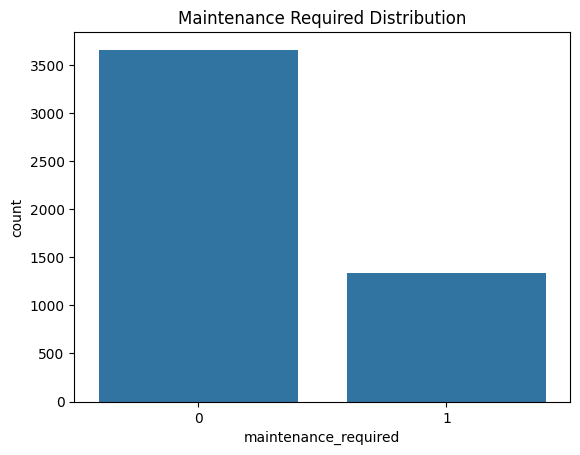

In [ ]:
# Check class balance
sns.countplot(x='maintenance_required', data=fwa_df)
plt.title('Maintenance Required Distribution')
plt.show()

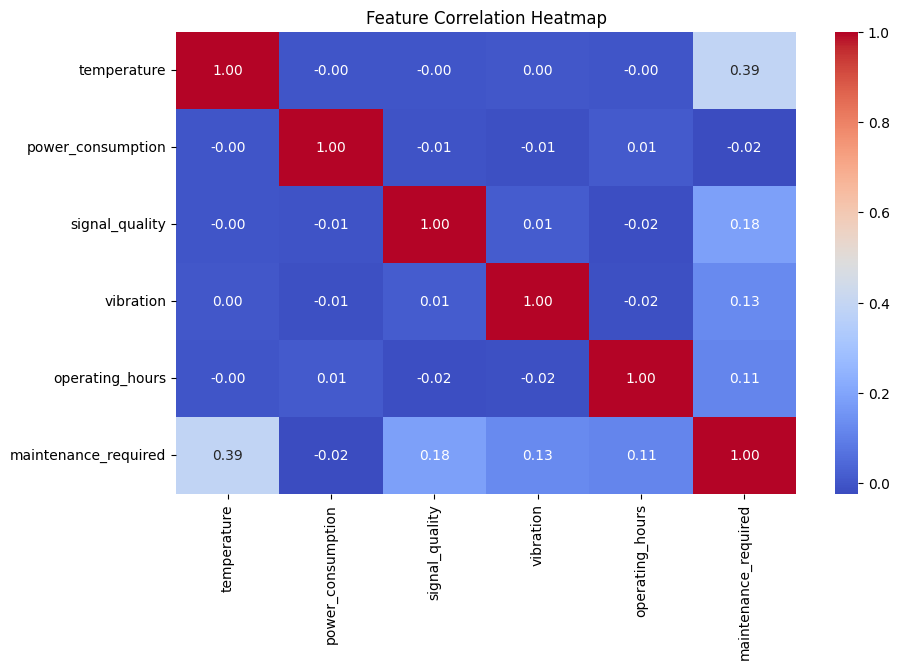

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(fwa_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

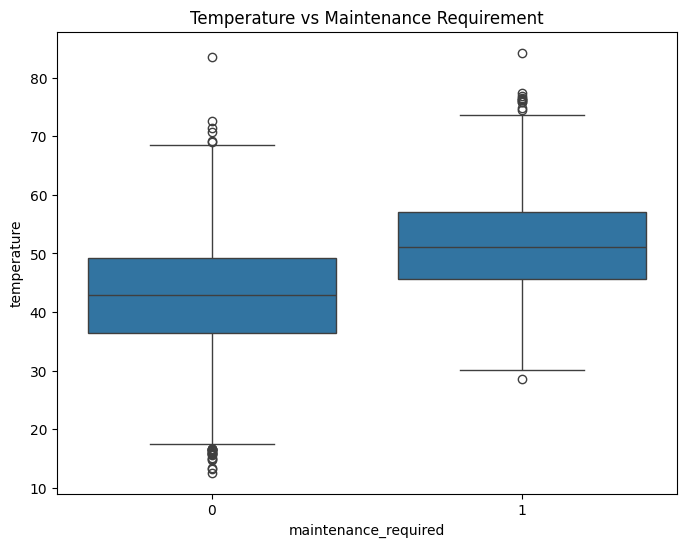

In [ ]:
# Temperature vs Maintenance
plt.figure(figsize=(8, 6))
sns.boxplot(x='maintenance_required', y='temperature', data=fwa_df)
plt.title('Temperature vs Maintenance Requirement')
plt.show()

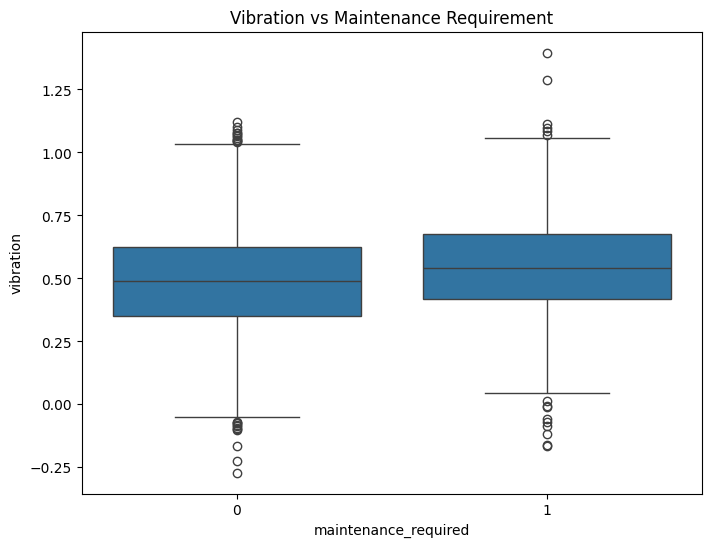

In [ ]:
# Vibration vs Maintenance
plt.figure(figsize=(8, 6))
sns.boxplot(x='maintenance_required', y='vibration', data=fwa_df)
plt.title('Vibration vs Maintenance Requirement')
plt.show()

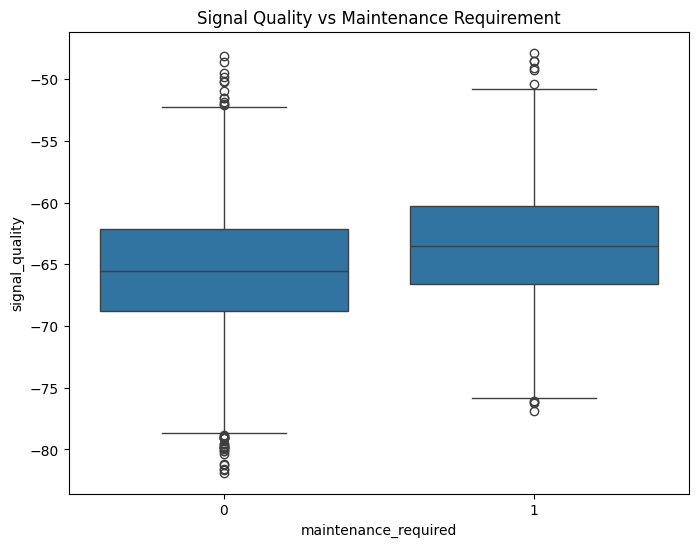

In [ ]:
# Signal Quality vs Maintenance
plt.figure(figsize=(8, 6))
sns.boxplot(x='maintenance_required', y='signal_quality', data=fwa_df)
plt.title('Signal Quality vs Maintenance Requirement')
plt.show()

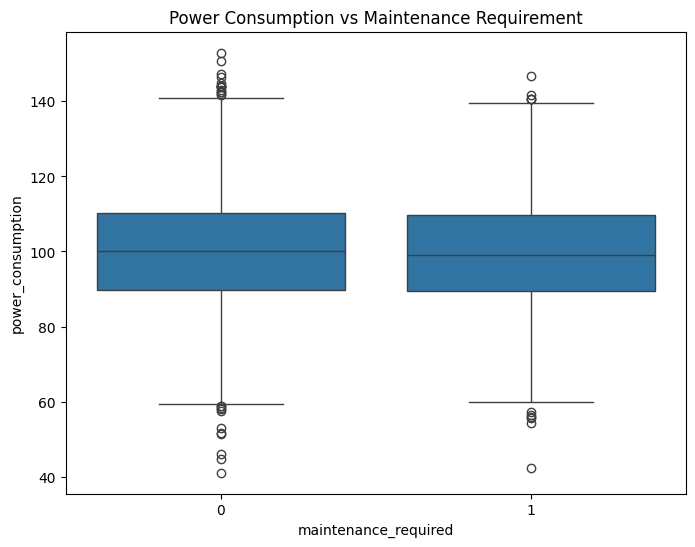

In [ ]:
# Power Consumption vs Maintenance
plt.figure(figsize=(8, 6))
sns.boxplot(x='maintenance_required', y='power_consumption', data=fwa_df)
plt.title('Power Consumption vs Maintenance Requirement')
plt.show()

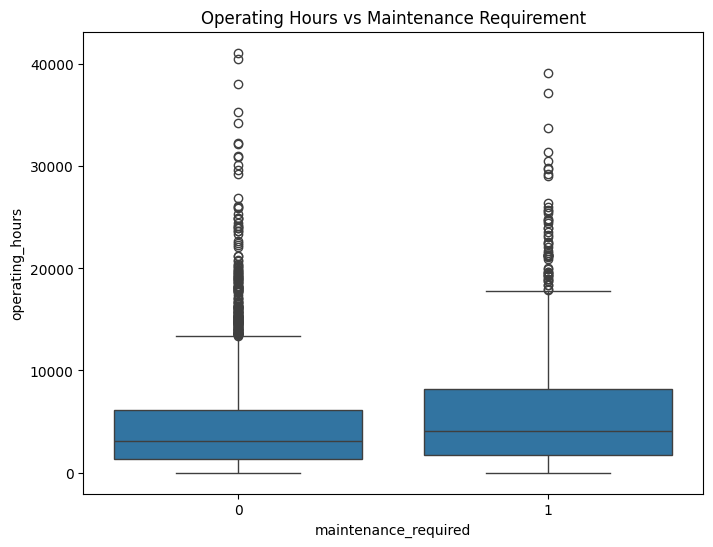

In [ ]:
# Operating Hours vs Maintenance
plt.figure(figsize=(8, 6))
sns.boxplot(x='maintenance_required', y='operating_hours', data=fwa_df)
plt.title('Operating Hours vs Maintenance Requirement')
plt.show()

# 🧠 Step 3: Train a Random Forest Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

In [ ]:
# Features and Target
X = fwa_df.drop('maintenance_required', axis=1)
y = fwa_df['maintenance_required']

In [ ]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
# Model: Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predictions
y_pred = rfc.predict(X_test)
y_pred_proba = rfc.predict_proba(X_test)[:, 1]

In [ ]:
# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_score:.2f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      1098
           1       0.61      0.34      0.44       402

    accuracy                           0.76      1500
   macro avg       0.70      0.63      0.64      1500
weighted avg       0.74      0.76      0.74      1500


Confusion Matrix:
[[1008   90]
 [ 264  138]]

ROC-AUC Score: 0.79


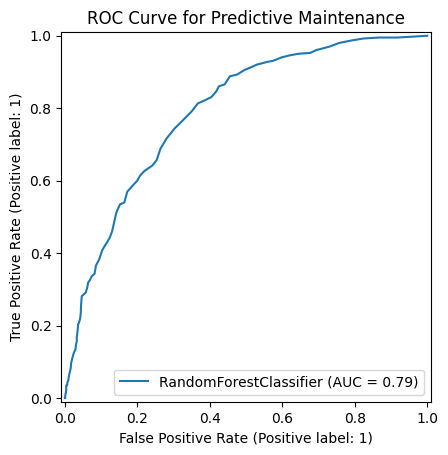

In [ ]:
# ROC Curve
RocCurveDisplay.from_estimator(rfc, X_test, y_test)
plt.title('ROC Curve for Predictive Maintenance')
plt.show()

# 🧠 Step 4: Plot Feature Importance

In [ ]:
# Feature Importance
importances = rfc.feature_importances_
feature_names = X.columns

In [ ]:
# Create a DataFrame for easier plotting
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

<ipython-input-19-7ada00e16f88>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


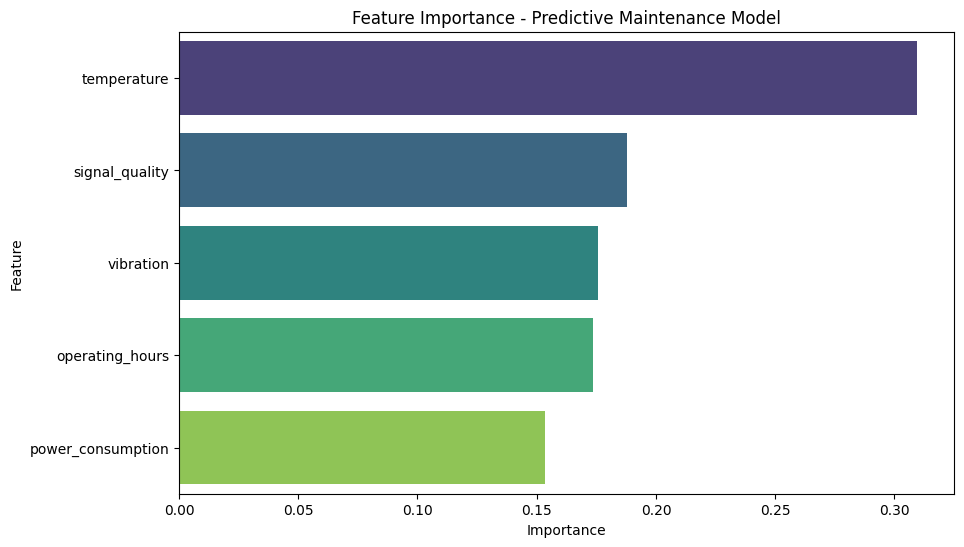

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance - Predictive Maintenance Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Step 5: Hyperparameter Tuning with GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [ ]:
# Setup GridSearch
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='roc_auc'
)

In [ ]:
# Run GridSearch
grid_search.fit(X_train, y_train)

# Best model
best_rfc = grid_search.best_estimator_

print(f"Best Parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


In [ ]:
# Evaluate Best Model
y_pred_best = best_rfc.predict(X_test)
y_pred_best_proba = best_rfc.predict_proba(X_test)[:, 1]

print("\nTuned Model Classification Report:")
print(classification_report(y_test, y_pred_best))

tuned_roc_score = roc_auc_score(y_test, y_pred_best_proba)
print(f"\nTuned ROC-AUC Score: {tuned_roc_score:.2f}")


Tuned Model Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.93      0.86      1098
           1       0.64      0.33      0.43       402

    accuracy                           0.77      1500
   macro avg       0.72      0.63      0.64      1500
weighted avg       0.75      0.77      0.74      1500


Tuned ROC-AUC Score: 0.80


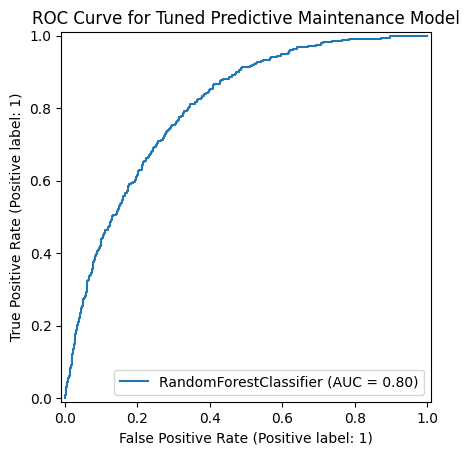

In [ ]:
# Plot ROC curve for tuned model
RocCurveDisplay.from_estimator(best_rfc, X_test, y_test)
plt.title('ROC Curve for Tuned Predictive Maintenance Model')
plt.show()

# 💾 Step 6: Save and Reload Your Model

In [ ]:
import joblib

# Save the best model to a file
model_filename = 'fwa_predictive_maintenance_model.joblib'
joblib.dump(best_rfc, model_filename)

print(f"Model saved as {model_filename}")

Model saved as fwa_predictive_maintenance_model.joblib


# 🔄 Reload the Model Later

In [ ]:
# Load the model
loaded_model = joblib.load(model_filename)

# Example: Predict using the loaded model
example_data = X_test.iloc[0:1]  # Take one example from test set
prediction = loaded_model.predict(example_data)
print(f"Maintenance prediction: {prediction[0]}")

Maintenance prediction: 0


# 🌟 Step 7: Create a Gradio App

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.3 MB/s eta 0:00:00


In [ ]:
import gradio as gr

# Define a prediction function
def predict_maintenance(temperature, power_consumption, signal_quality, vibration, operating_hours):
    input_data = pd.DataFrame({
        'temperature': [temperature],
        'power_consumption': [power_consumption],
        'signal_quality': [signal_quality],
        'vibration': [vibration],
        'operating_hours': [operating_hours]
    })
    prediction = loaded_model.predict(input_data)[0]
    probability = loaded_model.predict_proba(input_data)[0][1]

    if prediction == 1:
        result = f"⚠️ Maintenance Required! (Probability: {probability:.2f})"
    else:
        result = f"✅ Device Healthy (Probability: {probability:.2f})"
    return result

# Create Gradio Interface
interface = gr.Interface(
    fn=predict_maintenance,
    inputs=[
        gr.Number(label="Temperature (°C)"),
        gr.Number(label="Power Consumption (W)"),
        gr.Number(label="Signal Quality (dBm)"),
        gr.Number(label="Vibration (G)"),
        gr.Number(label="Operating Hours")
    ],
    outputs="text",
    title="📡 FWA Predictive Maintenance AI",
    description="Input device sensor values to predict if maintenance is required."
)

# Launch the app
interface.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://7ac617342588b4391b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Created dataset file at: .gradio/flagged/dataset1.csv
